In [18]:
from src.data.some_dataloader import RedditHyperlinkDataset, RedditPostDataset
from src.utils import plot_utils
from src.utils import data_utils
import importlib
importlib.reload(plot_utils)

<module 'src.utils.plot_utils' from 'c:\\Users\\Matteo\\Documents\\GitHub\\ada-2025-project-othertagada\\src\\utils\\plot_utils.py'>

# R/GamerGate

GamerGate is the text book example of manufactured outrage.
* r/kotakuinaction (kiA)
* r/gamerghazi (giA)

## 0. Datasets used

We used the additional dataset with post content but without link to enrich the analysis.

In [14]:
hyperlink_dataset = RedditHyperlinkDataset()
hl_data = hyperlink_dataset.data

In [3]:
post_dataset = RedditPostDataset()
post_data = post_dataset.data

## 1. Look at the actors

### 1.1 Selection of subreddits

We restrain the dataset to relevent subreddits to this aim we select the top subreddits with the most interactions (links ingoing and outgoing) with our two principal actors to have a selection of subreddits involved in the drama. To do so we very simply calculated for each subreddit the total number of links where r/kotakuinaction and r/gamerghazi appear as source or target. This sum was done seperatedly for the two of them so our analysis was not skewed by the fact that r/kotakuinaction has more links in total. Some subredits appear in both their top ten but some are only present for one.

In [48]:
plot_utils.plot_interactions(hl_data, 'gamerghazi', n=50)
plot_utils.plot_interactions(hl_data, 'kotakuinaction', n=50)

So only these 15 subreddits represent a good amount #insert percentage# of the links. Knowing that we have a total of #insert numbers# of subreddits in the dataset it is interesting to note that only a few restrained communities have the bulk of links to kiA and giA. These could be seen as subreddits that are part of a very specific online echo chamber. *It is to be noted that reddit is a platform inherently oriented to extremely online users and these type of drama are aimed at a very specific type of user. (to develop)*

We crop our datasets so that they only include these subreddits

In [15]:
gamerghazi_subs = data_utils.top_connected(hl_data, 'gamerghazi', n=10)
kotakuinaction_subs = data_utils.top_connected(hl_data, 'kotakuinaction', n=12)

subs_of_interest = (set(gamerghazi_subs.index) | set(kotakuinaction_subs.index) | {'gamerghazi', 'kotakuinaction'})
hl_data_cropped = hl_data[hl_data['SOURCE_SUBREDDIT'].isin(subs_of_interest) & hl_data['TARGET_SUBREDDIT'].isin(subs_of_interest)]

print("selected population : \n", hl_data_cropped['SOURCE_SUBREDDIT'].unique())



selected population : 
 ['subredditdrama' 'srssucks' 'circlebroke2' 'panichistory' 'drama'
 'shitredditsays' 'circlebroke' 'amrsucks' 'kotakuinaction' 'gamerghazi'
 'againstgamergate' 'shitghazisays' 'kiachatroom' 'shitliberalssay'
 'topmindsofreddit' 'ggfreeforall' 'bestofoutrageculture' 'ggdiscussion']


Let's see how these subreddits interact with our main actors

In [ ]:
## BAR PLOT LINKS ##

plot_utils.plot_stacked_bar_chart(hl_data_cropped, html_output=True)

### 1.2 Population of these subreddits

1.2.1 First Let's have a look at the populations that make up reddit in general.


In [ ]:
## Histogram nb post per user ## 

#math description of power law# (find coef of power law if feasable)

We have a power law distribution of the number of post by users, most user are "light" user, rarely posting and some few are "power" users, users that contribute to a large amount of the content on the subreddits. "ligth" users despite their rare posting might still look at a lot of post made by others and might be actif in the act of viewing and upping a post, those could be seen as spectators. "power" users are more alike to the leaders of the subreddits.

1.2.2 Is there a difference in negativity bewtween power user and light user ? 

To this purpose we realize a t ttest with the features is_power_user = 1 if more than #insert treshold# and is_power_user = 0 if less than #insert treshold# 

#describe type of t test and why#

In [ ]:
## plot average for power user against light user with variance##
## p test to see difference in link sentiment##

*JE CROIS QU'IL Y A PAS* 

#p value analysis#

Oh so there is no real difference in link sentiment average for power user and light user. Great! this is useful information to get a graps on the population of reddit. Power user or light user are similarly negative.

1.2.3 Similarity between selected subreddits

To understand better how the selected subreddits interact we first need to understand how their communities of users overlap (or don't!) We compute the Jaccard Similarity between each subreddit to contruct a heatmap of user similarity between subreddits in a very intuitive way.

#description of jaccard similarity#

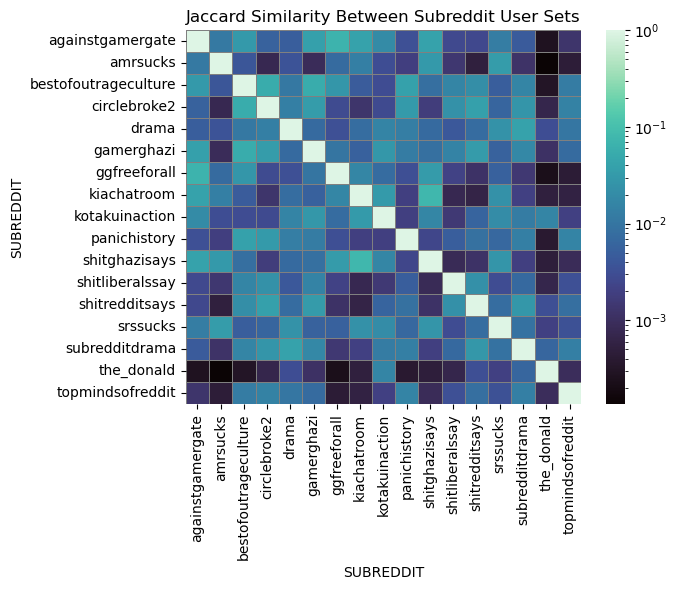

In [ ]:
plot_utils.plot_jaccard_similarity_user_heatmap(post_data)

A keen eye will have realised that the heatmap uses a logscale to color the values. The Jaccard similarity gives very low values that are hard to distinguish without a helpful log scaling. The low values are due to the sizes of the user set for each subreddit that are very big and with globally low overlapping. This is not suprising, as seen previoulsy, most users are light user and will not be seen on multiple subreddits.

#analysis of heatmap, most similar subreddits, least similar, anything intriguiging#

## 2. How it played out

Now that we are familiar with the actors it is time to get to work. We take advantage of the graph structure of the hypperlink dataset to plot the subreddits and display their interactions on a weekly basis for the duration of the conflict and in the aftermath. Use the slider to learn more abour the main events of Gamergate!

In [ ]:
from IPython.display import HTML

display(HTML("docs/assets/slider_graph_and_bar.html"))

ANALYSIS OF MAIN EVENTS, peaks in posts and links, define a clear date of start and end (useful for part 4)

## 3. Can negativity be predicted ?

As discussed before, this story is one of intense harassment, a huge part of managing these types of hate compaigns is content moderation. As of today content moderation relies mainly on models trained to detect hateful speach. Considering the cleaving topics discussed in gamergate, here we chose to consider a negative link from a subreddit to another as a sign of hate.

### 3.1 How negative is GamerGate ?

As a hate compaign we expect subreddits involved in the conflict to be more negative than reddit as a platform globally, but let's verify this assumption to make it a fact before going further. We compare the average negativity of the subreddits against the average of the link sentiment average per subreddit. 

In [ ]:
#BAR PLOT OF NEGATIVITY RATIO OF SUBREDDIT/GLOBAL LINK SENTIMENT AVERAGE#

So much negativity... but yay our assumption was verfied!

### 3.2 Predictions of link sentiment

To detect negativity we train a model of logistic regression on the hypperlink dataset (the total dataset not the one of only the selected subreddits).

#description of logistic regression#\
#description of chosen features#

In [ ]:
#plot of accuracy#

#discussion of accuracy, overfitting ?#

### 3.3 What are signs of negativity on reddit?

3.2.1 Feature importance

The logistic regression model is useful not only to classify a link as negative or positive but it also gives us a glimpse into which features are the most useful in the classification and if their presence has a positive or negative impact on the link sentiment.

In [ ]:
#plot features in order of coefficient value - to +#
#plot p value as well#

#Discussion of the results, what can be said about the most important features#
The semantic and linguistic features seem to have a bigger role at play than sentiment and topic based features. So the way a post is written is more telling than the topics detected to predict a negative link. (to develop with results)

### 3.4 Linguistic characteristics of Gamergaters 

*JE SAIS PAS, SI ON A LE TEMPS, LOOK INTO THE IMPORTANT FEATURES AND IF DIFFERENT FOR GAMERGATE VS TOTAL DATASET?*

## 4. Impact of manufactured outrage on politics (rough first draft)

GamerGate has been widely analysed post mortem and is now considered a text book exmaple of manifactured online outrage. Pushing communinities to more extrem views and all of these discutions are inherently political. (to develop)
We are not saying that GamerGate had any influence on the 2017 election, we are looking at the rise in online right wing extremism at the time and how online spaces were used to influence the election. (to reformulate I'm aware this is bad :)
* 4.1 word topic cluster (bubbles) with political topics to show political importance (The_donald political sub)
* 4.2 analysis of post gamergate plolitical leanings in Gamer subreddit or selected subreddit vs pre Gamergate (a voir si vrai ou pas)


In [ ]:
#IN THE WORKS LOL#

## 5. What becomes of these communites after the facts ?

While r/kotakuinaction and r/gamerghazi where created expressively with the goal of discussing the subject of GamerGate, these subreddits (like many others) do not die down suddenly after the events. These subreddits continue posting years after the peak of the conflict, identified earlier as starting from #insert start date# and lasting approximatively until #insert end date#.

### 5.1 Decline in activity...

It is not surprising that the activity slows down significantly

In [ ]:
#plot nb of post per week both#

### 5.2 ...But the activity is not null

So what are the discussion made of if echanges are still being made on those subreddits ? To analyze the changing trends in the topics discussed on each subreddit we have turn NLP technics (Natural Language Processing).\

5.2.1 Creation of topic categories

We use the tool Empath #link to description of empath# to create categories of topics related to our analysis.\
#description of Empath#\
Empath even offers a model trained on data from reddit that is perfect for our analysis, sweet!

Our custom topics :
* Gamergate : Everything related to the actual events that sparked gamergate
* Mysogyny : Signs of mysogyny, sexims and violence against women.
* Legal : Legal speech, trial 
* Incel : Incel retoric


In [ ]:
#Print custom categories#

The output given by empath seems relevant term such as #insert terms# and #other terms# were correctly infered from the given seed words. 

5.2.2 Monthly analysis

We compute the normalize values of relevance for each topic monthly. 

In [ ]:
#Monthly plot for kia#
#Monthly plot for gia#

We can see a clear peak in the gamergate topics coienciding with the peak in post on the subreddit at #insert date#.\
Decline in interest in main topic.\
In r/gamerghazi, in the aftermath, the subreddit is mostly used to discuss the incel movement.(to develop)\
Legal picks up in importance as the legal ramifications of GamerGate slowly surface. Did you know that the FBI was implicated multiple times in this story ?!


5.2.3 Comparaison with baseline

Just to be sure of our technic let's see what happens when we compute the same values for a subreddit that is not part of the gamerghazi drama. We chose the very active r/gaming subreddit.

In [ ]:
#Monthly plot for random gaming subreddit#

The topics look almost irrelevant for this subreddit, this confirm that our analysis had grounds. 

## 6. Conclusion